In [5]:
from src.utils import IoU
from src.dataloaders.brats import BRATS
from src.dataloaders.elastic_trans import BRATS as EL_BRATS
from src.models.unet import UNet
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.filters

def entropy_pixelwise(image):
    entropy_image = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            p = image[i, j]
            if p == 0 or p == 1:
                entropy_val = 0.0
            else:
                entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
            entropy_image[i, j] = entropy_val
    return entropy_image

def std_pixelwise(image, neighborhood_size=3):
    padded_image = np.pad(image, (neighborhood_size//2, neighborhood_size//2), mode='constant')
    std_dev_image = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+neighborhood_size, j:j+neighborhood_size]
            std_dev_image[i, j] = np.std(neighborhood)
    return std_dev_image

def mean_pixelwise(image, mask_size=3):
    mask = np.ones((mask_size, mask_size)) / mask_size*mask_size
    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='edge')
    mean_values = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            neighborhood = padded_image[i:i+3, j:j+3]
            val = np.sum(neighborhood * mask)
            mean_values[i, j] = val
    return mean_values

def is_binary_image(image_array):
    unique_values = np.unique(image_array)
    if len(unique_values) <= 2:
        return True
    else:
        return False

def get_binary_entropy(image):
    flat_image = image.flatten()
    p = np.mean(flat_image)
    if p == 0 or p == 1:
        entropy_val = 0.0
    else:
        entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy_val

def get_entropy(image):
    flat_image = image.flatten()
    p = np.mean(flat_image)
    if p == 0 or p == 1:
        entropy_val = 0.0
    else:
        entropy_val = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy_val

def get_std(image):
    return np.std(image)

def get_mean(image):
    return np.mean(image)

def add_gaussian_noise(image, intensity_range, mean=0, std=0.01):
    scaled_std = std * intensity_range
    noise = np.random.normal(mean, scaled_std, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, np.min(image), np.max(image))
    return noisy_image

In [11]:
dataloaders = []
hgg_set = BRATS('../../../../special-course/data/MICCAI_BraTS_2018_Data_Training', mode='test-hgg', subset=0.6, size=[64, 64, 155])
hgg_dataloader = torch.utils.data.DataLoader(hgg_set, batch_size=16, shuffle=False, drop_last=False)
dataloaders.append(hgg_dataloader)
lgg_set = BRATS('../../../../special-course/data/MICCAI_BraTS_2018_Data_Training', mode='test-lgg', subset=0.6, size=[64, 64, 155])
lgg_dataloader = torch.utils.data.DataLoader(lgg_set, batch_size=16, shuffle=False, drop_last=False)
dataloaders.append(lgg_dataloader)

# path = "../../../results/res-fanciful-disco-117/" # ensemble 10 - early stop 20
path = "../../../results/res-jolly-morning-122/" # dropout ensemble 10 - early stop 20

models = [file for file in os.listdir(path) if file.endswith('.pth')]
models = sorted(models)
print('Amount of models:', len(models), ' Amount of validation images:', len(hgg_dataloader), len(lgg_dataloader))


Amount of models: 10  Amount of validation images: 611 223


In [13]:
model = UNet('test-iou')
model.load_state_dict(torch.load(path + models[9]))


def vis_im_intens(image):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.imshow(image)#, cmap='gray', vmin=0, vmax=1)
    ax1.set_title('Image')
    ax1.axis('off')

    hist_values, bins, _ = ax2.hist(image.ravel(), bins=256, range=(0, 1), color='black', edgecolor='black')
    ax2.set_title('Intensity Histogram')
    ax2.set_xlabel('Intensity Value')
    ax2.set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
HGG 0 383 3274.0
383 0 hgg


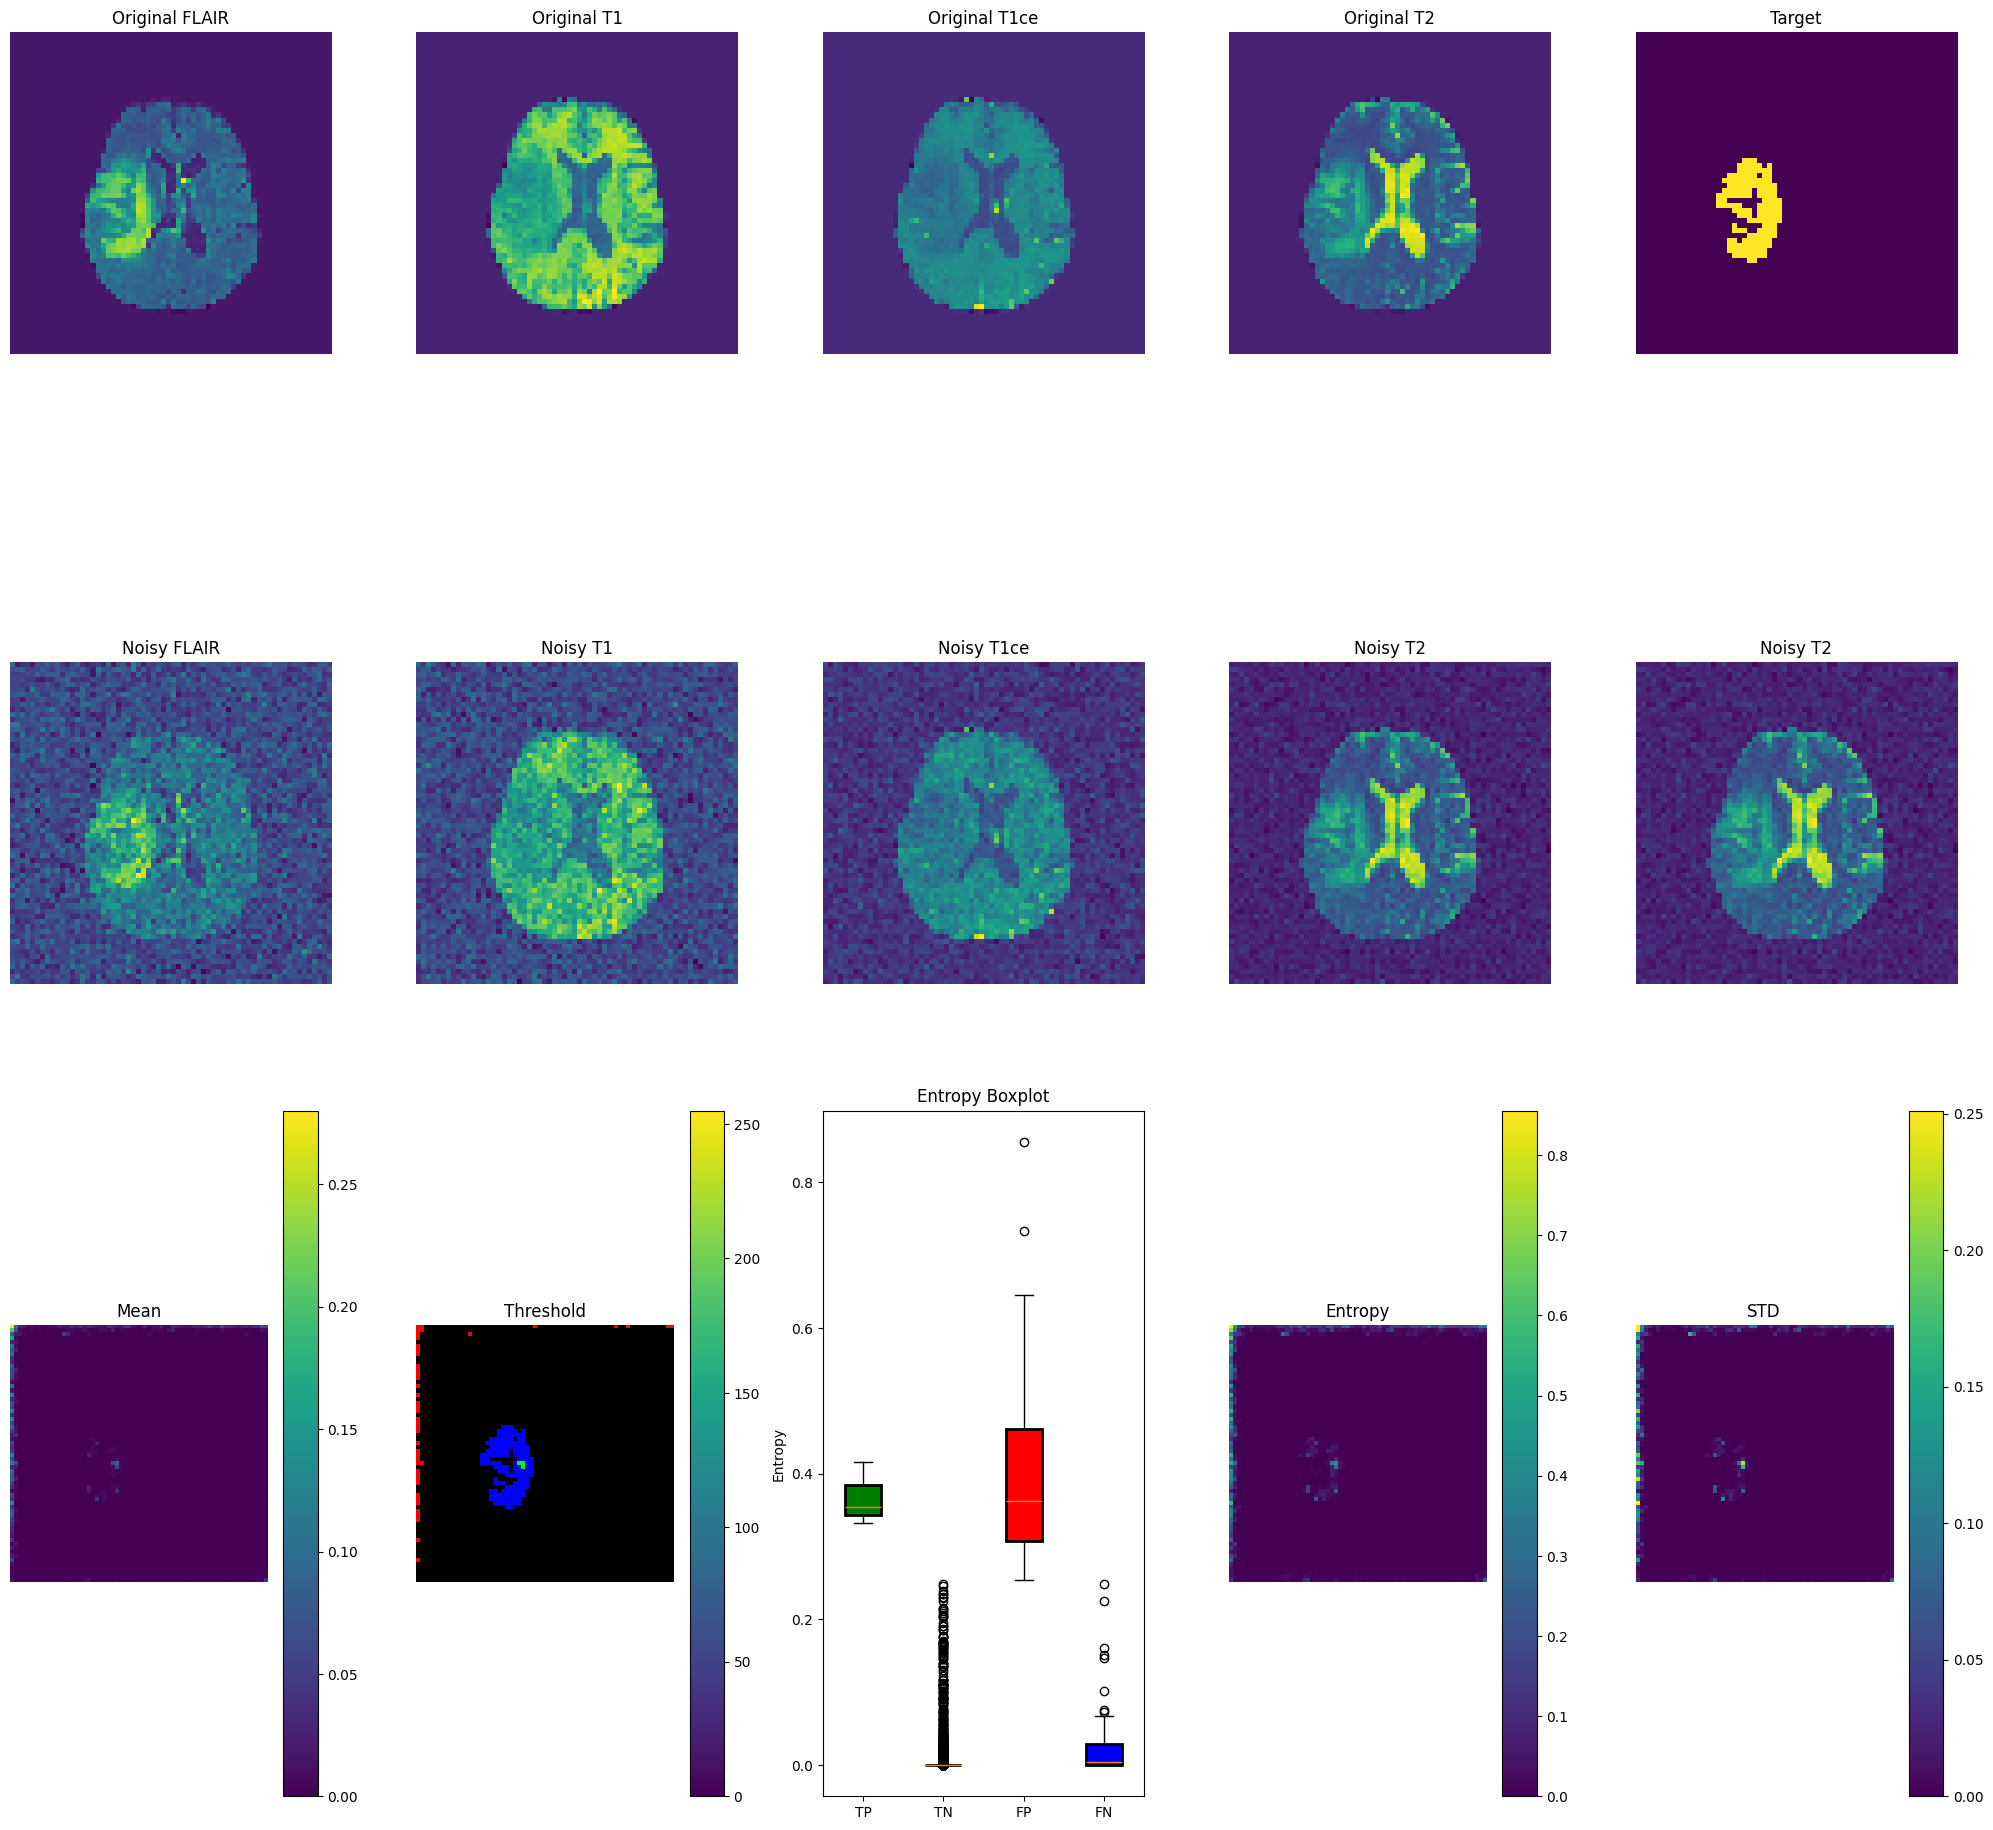

LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
LGG 1 139 5741.0
139 1 lgg


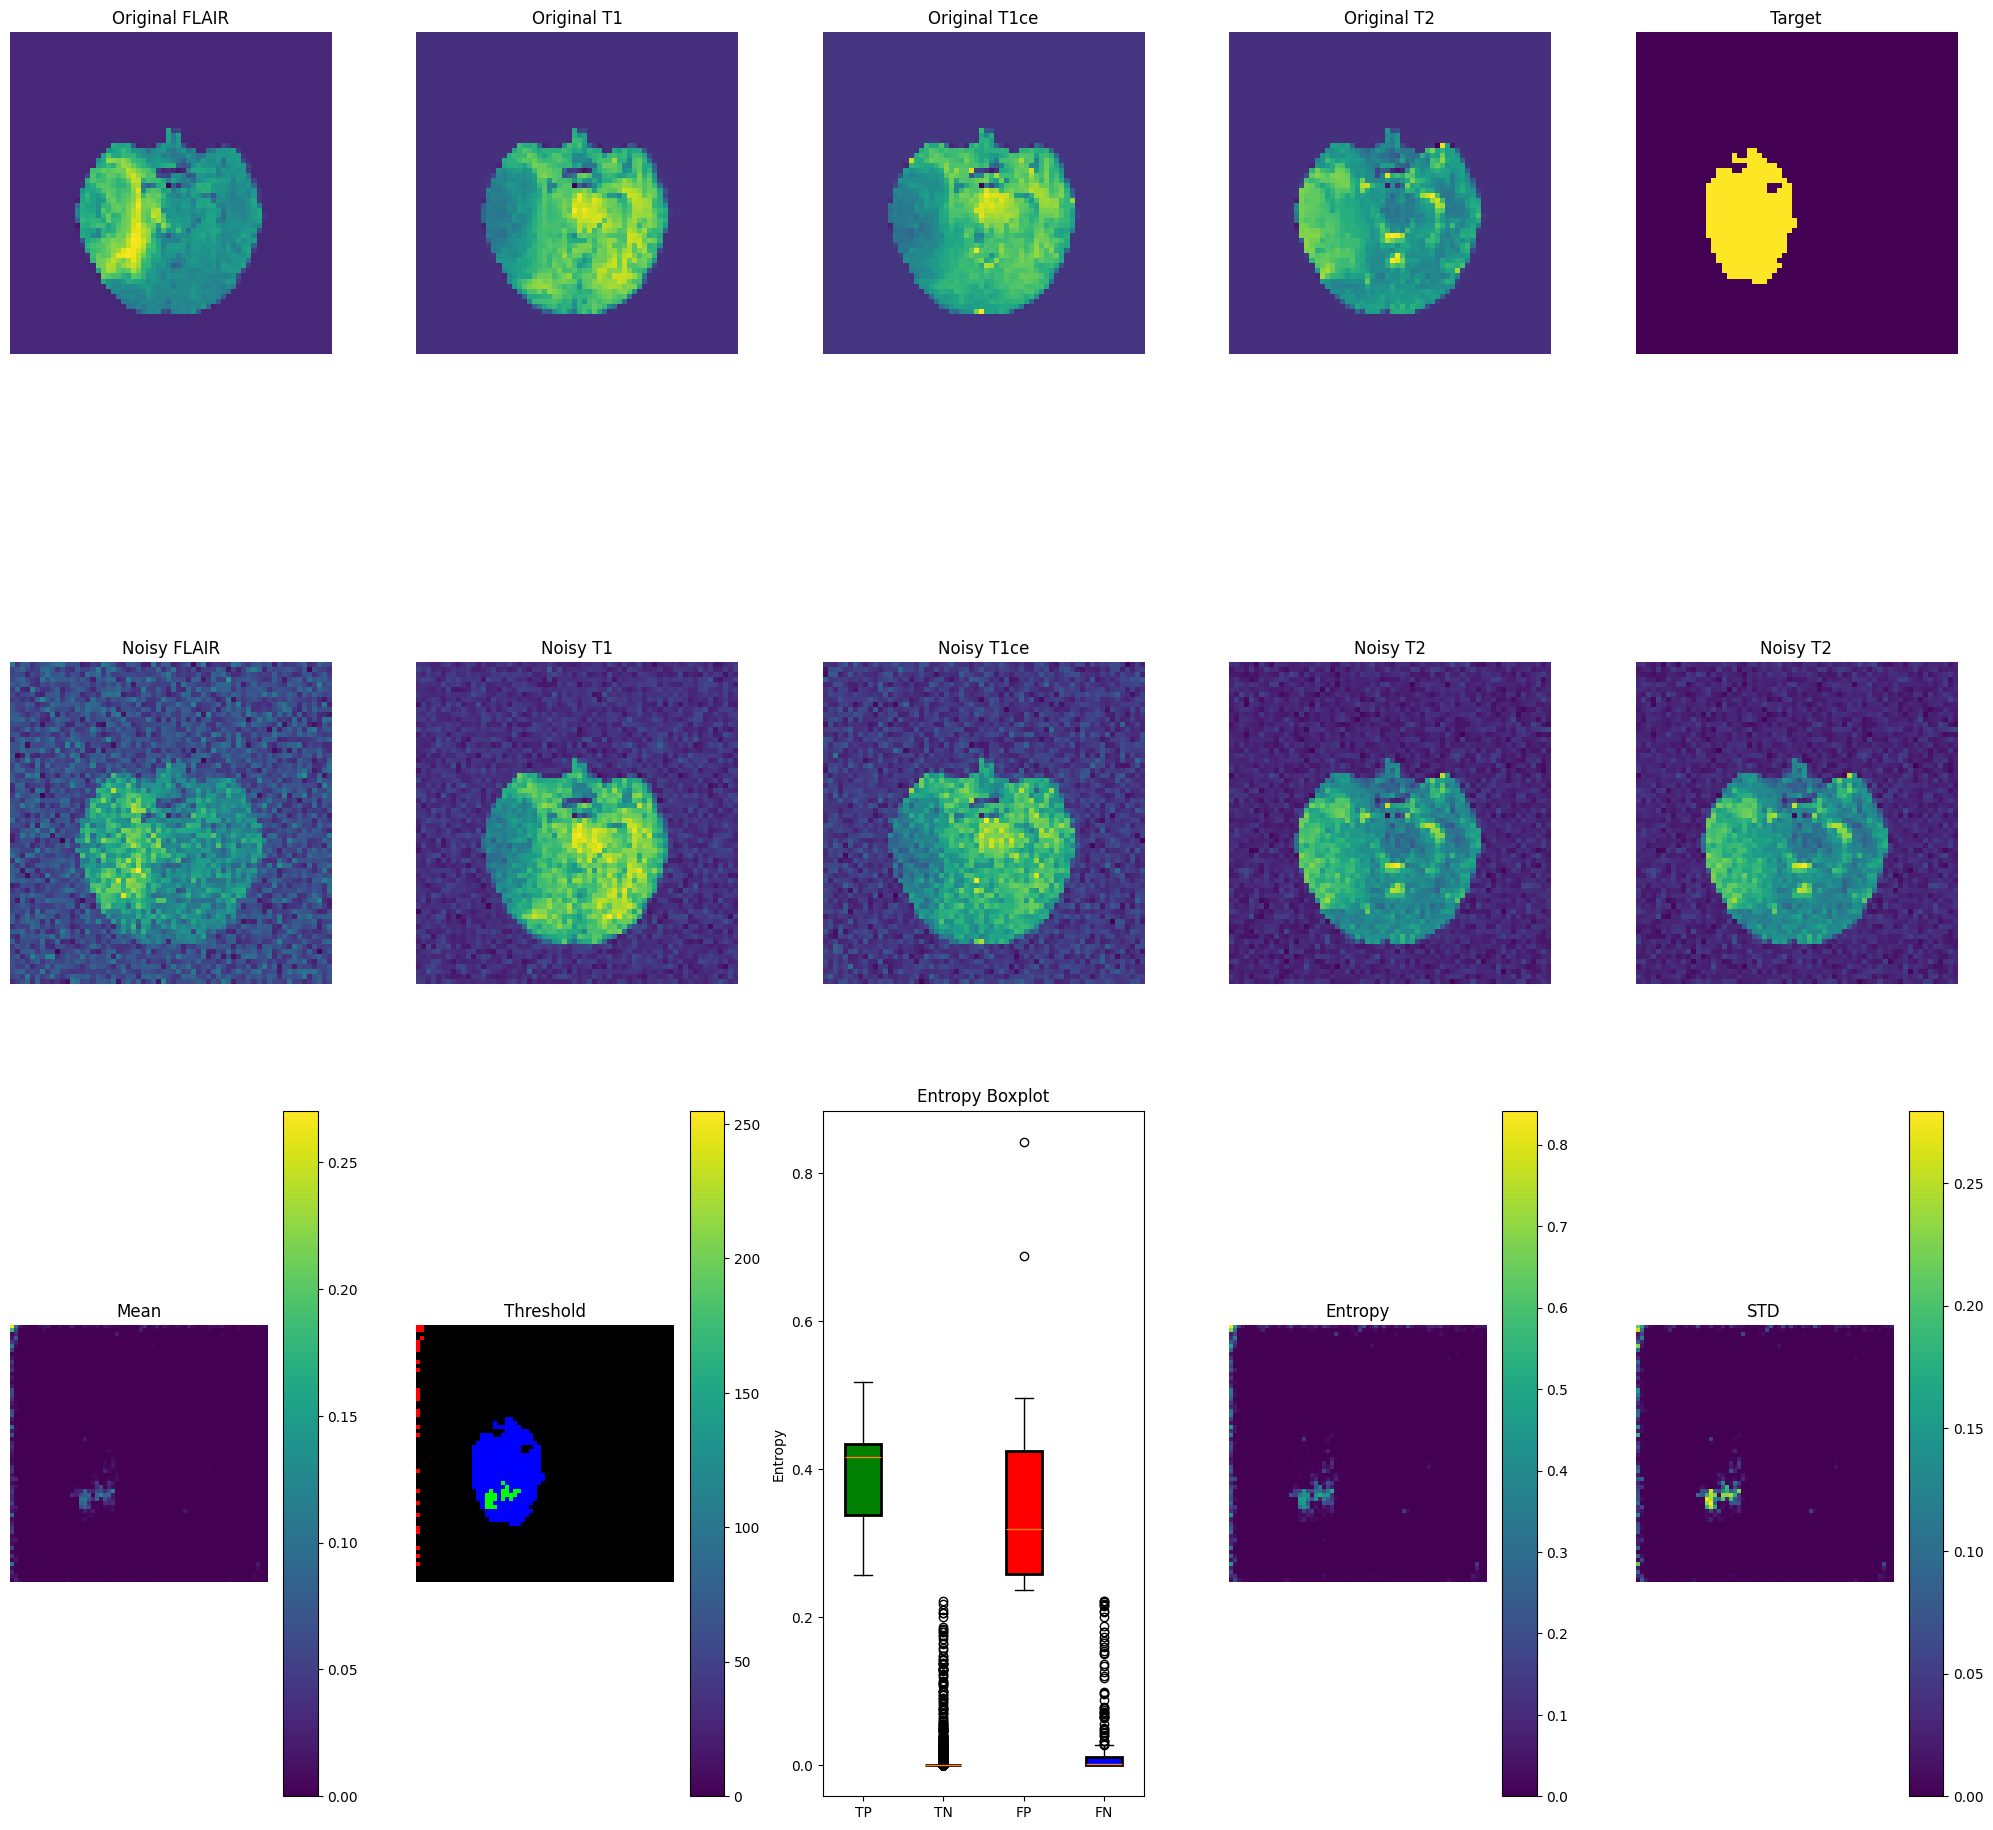

In [14]:
ious = []
ious_all = []

losses = []
losses_all = []

means_hgg = []
means_lgg = []
means_empty = []
entropies_hgg = []
entropies_lgg = []
entropies_empty = []
stds_hgg = []
stds_lgg = []
stds_empty = []

empty_counter = 0
ranges = []
for i in range(len(dataloaders)):
    pos_weight = 0.0103 if i == 0 else 0.0074
    for index, (inputs, targets, _) in enumerate(dataloaders[i]):
        # Add in case of visualosation:
        # if not ((i == 0 and index == 383) or (i == 1 and index == 139)):
        #     continue
        train_iou = 0.0
        train_loss = 0.0
        train_entropy = 0.0
        train_std = 0.0
        train_mean = 0.0
        iou_arr = []
        loss_arr = []
        ent_arr = []
        std_arr = []
        mean_arr = []
        np_img = inputs.detach().numpy()
        np_target = targets.detach().numpy()
        noisy_arr_pred = []
        noisy_arr_img = []
        for noisy_index in range(10):
            intensity_range = np.max(np_img) - np.min(np_img)
            ranges.append(intensity_range)
            noisy_img = add_gaussian_noise(np_img, intensity_range, std=0.1)
            noisy_img = torch.from_numpy(noisy_img).float()
            noisy_arr_img.append(noisy_img)

            logits = model(noisy_img)
            criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
            np_pred = torch.sigmoid(logits.detach()).numpy()
            np_pred = np_pred[0, 0, :, :]
            noisy_arr_pred.append(np_pred)
            loss = criterion(logits, targets)
            train_loss += float(loss)
            loss_arr.append(float(loss))
            iou = float(IoU(targets.detach(), torch.sigmoid(logits.detach()).ge(0.5)))
            train_iou += iou
            iou_arr.append(iou)
            if np_target.sum() == 0.0:
                ious.append(np.NAN)
                losses.append(np.NAN)
                ious_all.append(np.mean(iou_arr))
                losses_all.append(np.mean(loss_arr))
                empty_counter += 1
                print('EMPTY', i, index, np_target.sum(), empty_counter)
            elif i == 0:
                ious.append(np.mean(iou_arr))
                losses.append(np.mean(loss_arr))
                ious_all.append(np.mean(iou_arr))
                losses_all.append(np.mean(loss_arr))
                print('HGG', i, index, np_target.sum())
            elif i == 1:
                ious.append(np.mean(iou_arr))
                losses.append(np.mean(loss_arr))
                ious_all.append(np.mean(iou_arr))
                losses_all.append(np.mean(loss_arr))
                print('LGG', i, index, np_target.sum())
        cur_mean = np.mean(noisy_arr_pred, axis=0)
        thres = skimage.filters.threshold_otsu(cur_mean)
        cur_pred = (cur_mean > thres).astype(np.uint8)  # Or np.bool_ for boolean array
        cur_std = np.std(noisy_arr_pred, axis=0)
        cur_entropy = entropy_pixelwise(cur_mean)

        new_img = np.mean(noisy_arr_img, axis=0)
        if np_target.sum() == 0.0:
            entropies_empty.append(np.mean(cur_entropy))
            means_empty.append(np.mean(cur_mean))
            print(index, i, 'empty')
        elif i == 0:
            entropies_hgg.append(np.mean(cur_entropy))
            means_hgg.append(np.mean(cur_mean))
            print(index, i, 'hgg')
        elif i == 1:
            entropies_lgg.append(np.mean(cur_entropy))
            means_lgg.append(np.mean(cur_mean))
            print(index, i, 'lgg')

        # if (i == 0 and index == 383) or (i == 1 and index == 139):
        if np_target.sum() > 100:
            fig, axes = plt.subplots(3, 5, figsize=(20,20))
            axes[0][0].imshow(np_img[0, 0, :, :])
            axes[0][0].set_title('Original FLAIR')
            axes[0][0].axis('off')

            axes[0][1].imshow(np_img[0, 1, :, :])
            axes[0][1].set_title('Original T1')
            axes[0][1].axis('off')

            axes[0][2].imshow(np_img[0, 2, :, :])
            axes[0][2].set_title('Original T1ce')
            axes[0][2].axis('off')

            axes[0][3].imshow(np_img[0, 3, :, :])
            axes[0][3].set_title('Original T2')
            axes[0][3].axis('off')

            np_target = np_target[0, 0, :, :]
            axes[0][4].imshow(np_target)
            axes[0][4].set_title('Target')
            axes[0][4].axis('off')

            axes[1][0].imshow(new_img[0, 0, :, :])
            axes[1][0].set_title('Noisy FLAIR')
            axes[1][0].axis('off')

            axes[1][1].imshow(new_img[0, 1, :, :])
            axes[1][1].set_title('Noisy T1')
            axes[1][1].axis('off')

            axes[1][2].imshow(new_img[0, 2, :, :])
            axes[1][2].set_title('Noisy T1ce')
            axes[1][2].axis('off')

            axes[1][3].imshow(new_img[0, 3, :, :])
            axes[1][3].set_title('Noisy T2')
            axes[1][3].axis('off')

            axes[1][4].imshow(new_img[0, 3, :, :])
            axes[1][4].set_title('Noisy T2')
            axes[1][4].axis('off')

            combined_image = np.zeros((64, 64, 3), dtype=np.uint8)
            combined_image[(np_target == 1) & (cur_pred == 1)] = [0, 255, 0] # tp - green
            combined_image[(np_target == 0) & (cur_pred == 1)] = [255, 0, 0] # fp - red
            combined_image[(np_target == 0) & (cur_pred == 0)] = [0, 0, 0] #tn - black
            combined_image[(np_target == 1) & (cur_pred == 0)] = [0, 0, 255] # fn - blue

            im2 = axes[2][0].imshow(cur_mean)
            axes[2][0].set_title("Mean")
            axes[2][0].axis('off')
            fig.colorbar(im2, ax=axes[2][0])

            im6 = axes[2][1].imshow(combined_image)
            axes[2][1].set_title('Threshold')
            axes[2][1].axis('off')
            fig.colorbar(im6, ax=axes[2][1])

            tp_entropy = cur_entropy[(combined_image[:, :, 0] == 0) & (combined_image[:, :, 1] == 255) & (combined_image[:, :, 2] == 0)] # tp green
            fp_entropy = cur_entropy[(combined_image[:, :, 0] == 255) & (combined_image[:, :, 1] == 0) & (combined_image[:, :, 2] == 0)] # fp red
            tn_entropy = cur_entropy[(combined_image[:, :, 0] == 0) & (combined_image[:, :, 1] == 0) & (combined_image[:, :, 2] == 0)] # tn black
            fn_entropy = cur_entropy[(combined_image[:, :, 0] == 0) & (combined_image[:, :, 1] == 0) & (combined_image[:, :, 2] == 255)] # fn blue
            boxplot_data = [tp_entropy, tn_entropy, fp_entropy, fn_entropy]
            boxprops = dict(linewidth=2.0)
            bplot = axes[2][2].boxplot(boxplot_data, patch_artist=True, boxprops=boxprops, labels=['TP', 'TN', 'FP', 'FN'])
            colors = ['green', 'black', 'red', 'blue']

            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)

            axes[2][2].set_title('Entropy Boxplot')
            axes[2][2].set_ylabel('Entropy')


            im4 = axes[2][3].imshow(cur_entropy)
            axes[2][3].imshow(cur_entropy)
            axes[2][3].set_title("Entropy")
            axes[2][3].axis('off')
            fig.colorbar(im4, ax=axes[2][3])

            im3 = axes[2][4].imshow(cur_std)
            axes[2][4].imshow(cur_std)
            axes[2][4].set_title("STD")
            axes[2][4].axis('off')
            fig.colorbar(im3, ax=axes[2][4])

            plt.tight_layout()
            plt.show()


In [23]:
print('INTENS RANGES', len(ranges), np.min(ranges), np.max(ranges), np.mean(ranges))
print('----- iou mean')
print('ious 2',  len([val for val in ious if not np.isnan(val)]), np.mean([val for val in ious if not np.isnan(val)]))
print('ious_all', len(ious_all), np.mean(ious_all))

print('-----iou std')
print('ious 2',  len([val for val in ious if not np.isnan(val)]), np.std([val for val in ious if not np.isnan(val)]))
print('ious_all', len(ious_all), np.std(ious_all))

print('-----loss mean')
print('losses 2',  len([val for val in losses if not np.isnan(val)]), np.mean([val for val in losses if not np.isnan(val)]))
print('losses_all', len(losses_all), np.mean(losses_all))

# print('-----loss std')
# print('losses', len(losses), np.std(losses))
# print('losses 2',  len([val for val in losses if not np.isnan(val)]),
#       np.std([val for val in losses if not np.isnan(val)]))
# print('losses_all', len(losses_all), np.std(losses_all))

INTENS RANGES 20 1212.0 5235.0 3223.5
----- iou mean
ious 2 20 0.14546039971889804
ious_all 20 0.14546039971889804
-----iou std
ious 2 20 0.14092348692989184
ious_all 20 0.14092348692989184
-----loss mean
losses 2 20 0.006165523657165025
losses_all 20 0.006165523657165025


hgg 324 lgg 120 em 388
e 2.4628373990865517 1.7108542328763927 2.184918868127366
m 0.7156091276556253 0.488190446048975 0.6231235340237617
e 2.362139074116298 1.525813384228549 2.3335551220106105
m 0.7026807870715857 0.4369380883872509 0.6650292314589024
e 3.9384534285299067 1.7450709415411838 2.7130482479009412
m 1.3482890091836452 0.5196740850806236 0.7485754787921906
e 3.9898085428670544 2.0561647383932633 2.2937802366961058
m 1.390782743692398 0.5914655514061451 0.6662392988801003
e 4.276261313120818 1.984584598751634 2.3603222294086907
m 1.4199450612068176 0.5560840480029583 0.7086325436830521


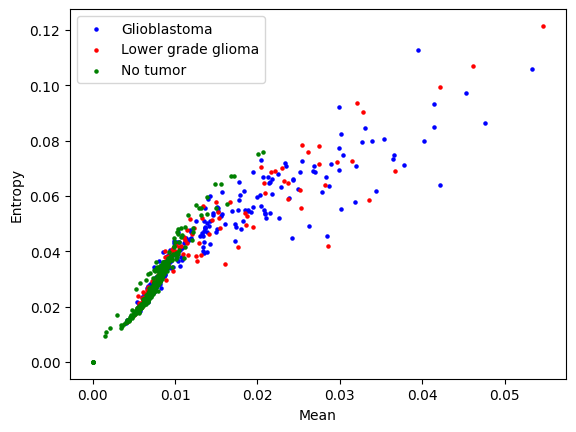

In [117]:
import matplotlib.pyplot as plt

colors = ['blue', 'red', 'green']

print('hgg', len(entropies_hgg), 'lgg', len(entropies_lgg), 'em', len(entropies_empty))

for i in range(5):
    print('e', entropies_hgg[i]*100, entropies_lgg[i]*100, entropies_empty[i]*100)
    print('m', means_hgg[i]*100, means_lgg[i]*100, means_empty[i]*100)

plt.scatter(means_hgg, entropies_hgg, color=colors[0], s=5, label='Glioblastoma')
plt.scatter(means_lgg, entropies_lgg, color=colors[1], s=5, label='Lower grade glioma')
plt.scatter(means_empty, entropies_empty, color=colors[2], s=5, label='No tumor')

plt.xlabel('Mean')
plt.ylabel('Entropy')

plt.legend()
plt.show()

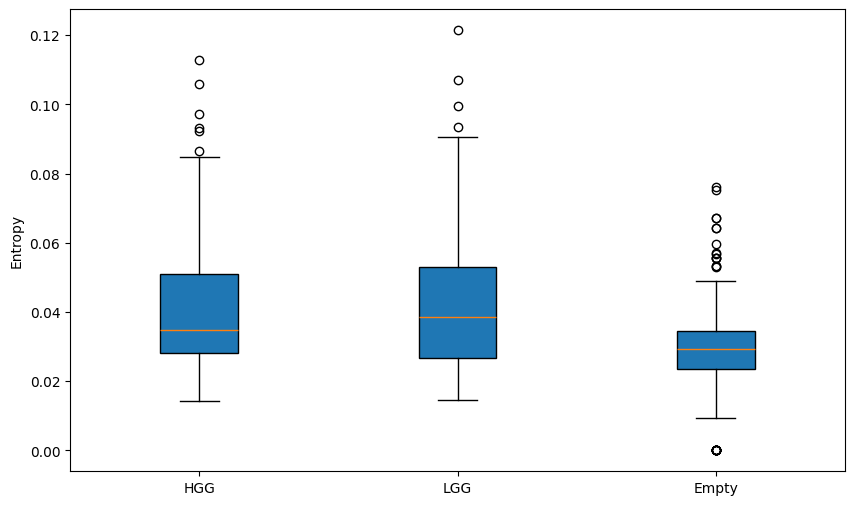

In [118]:
import numpy as np
import matplotlib.pyplot as plt

data = [entropies_hgg, entropies_lgg, entropies_empty]

fig, ax = plt.subplots(figsize=(10, 6))

ax.boxplot(data, patch_artist=True)

ax.set_xticklabels(['HGG', 'LGG', 'Empty'])

ax.set_ylabel('Entropy')

# Show the plot
plt.show()
